In [1]:
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
import scipy.spatial.distance as dist

import IBloFunMatch_inter as ibfm
output_dir = "output"

EXECUTABLE_PATH: /mnt/c/Users/Alvaro/Documents/repositories/IBloFunMatch/build/IBloFunMatch


This notebook illustrates the difficulty with matching stability that might come up with nesting behavour of bars.
First, sample a pair of circles and take a sample from them.

In [2]:
rng = default_rng(2)
r = 10
radius = rng.uniform(r-0.4*r, r+0.4*r, 100)
angle = np.pi * rng.uniform(0, 2, 100)
r=8
C1 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()
radius = rng.uniform(r-0.4*r, r+0.4*r, 80)
angle = np.pi * rng.uniform(0, 2, 80)
C2 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()+[0,6.5]
Y=np.vstack((C1,C2))

In [3]:
subset_indices = rng.choice(range(len(Y)), replace=False, size=110)
center_pts_bool = np.sqrt(np.sum((Y-[0,3.5])**2, axis=1))<1.4
subset_indices = [idx for idx in subset_indices if not center_pts_bool[idx]]
X = Y[subset_indices]

In [4]:
%%capture
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y))
IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, output_dir)

WELCOME TO IBLOFUNMATCH!!!
sorted sample indices, total: 86
Reading distance Matrices.
Finished reading matrices and sample indices.
sorted S according to new order
stored new sorted distance matrix
Correctly checked inequality on dist_S and dist_X
Welcome to PerMoVEC!
The subcomplex contains 492 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 2629 simplices  after collapse. 
   and has dimension 2 
Cycle columns image: 
Checking zero columns:
0 PM_matrix:
2, 
9, 
13, 
14, 
16, 
23, 
30, 
36, 
41, 
43, 
48, 
33, 
54, 
59, 
3, 26, 34, 
64, 
66, 
69, 
73, 
78, 
92, 
93, 
95, 
72, 91, 
19, 37, 65, 
32, 81, 
105, 
106, 
75, 84, 
112, 
26, 115, 
19, 68, 
118, 
119, 
122, 
123, 
124, 
128, 
131, 
132, 
42, 135, 
137, 
80, 135, 
8, 32, 87, 
143, 
28, 77, 82, 86, 91, 142, 
105, 110, 148, 
115, 126, 
77, 82, 86, 
81, 150, 
39, 83, 90, 125, 
35, 139, 148, 
154, 
150, 156, 
96, 123, 136, 
68, 75, 79, 97, 125, 155, 164, 
75, 79, 83, 125, 
117, 141, 
108, 152, 156, 
75, 

Notice that the induced matching and the induced block functions are different in dimension 1

In [5]:
IBloFunMatch_o["induced_matching_1"]

[6, 11, 14, 16, 18, 17]

In [6]:
IBloFunMatch_o["block_function_1"]

[6, 11, 14, 16, 18, 18]

In [7]:
IBloFunMatch_o["pm_matrix_1"]

[[6], [11], [14], [16], [17, 18], [18]]

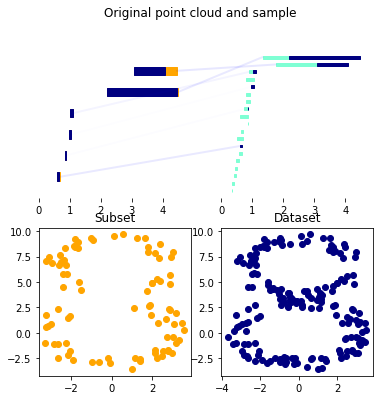

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(Y[:,0], Y[:,1], c="navy")
ax[1,0].set_title("Subset")
ax[1,1].set_title("Dataset")
ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
fig.suptitle("Original point cloud and sample")
plt.savefig("plots/stability/two_circles.png")

Loop through noisy samples of the same pair.

In [9]:
%%capture
rng = default_rng(10)
for idx in range(10):
    eps = 0.1*(1+idx)
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o2 = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    ibfm.plot_matching(IBloFunMatch_o2, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}")
    plt.savefig(f"plots/stability/two_circles{idx}.png")

WELCOME TO IBLOFUNMATCH!!!
sorted sample indices, total: 86
Reading distance Matrices.
Finished reading matrices and sample indices.
sorted S according to new order
stored new sorted distance matrix
Correctly checked inequality on dist_S and dist_X
Welcome to PerMoVEC!
The subcomplex contains 547 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 1757 simplices  after collapse. 
   and has dimension 2 
Cycle columns image: 
Checking zero columns:
0 PM_matrix:
4, 
9, 
11, 
12, 
16, 
7, 18, 
26, 
28, 
32, 
37, 
38, 
39, 
14, 45, 
51, 
58, 
65, 
66, 
68, 
74, 
75, 
76, 
77, 
79, 
86, 
2, 83, 
18, 82, 
94, 
96, 
98, 
45, 52, 102, 
104, 
105, 
108, 
118, 
106, 
95, 102, 
121, 
116, 122, 
17, 109, 
127, 
129, 
135, 
20, 73, 100, 
35, 112, 
144, 
88, 146, 
67, 85, 92, 109, 111, 145, 148, 
36, 113, 
149, 
23, 36, 40, 71, 
82, 107, 123, 150, 
3, 87, 97, 125, 
123, 
88, 89, 
150, 
146, 159, 
10, 122, 142, 
85, 92, 111, 112, 
59, 80, 114, 
113, 164, 
164, 165, 
85, 92, 10

In [10]:
%%capture
rng = default_rng(10)
eps = 0.4
for idx in range(10):
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o2 = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    ibfm.plot_matching(IBloFunMatch_o2, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}, iteration= {idx}")
    plt.savefig(f"plots/stability/two_circ_noise_const_{idx}.png")

WELCOME TO IBLOFUNMATCH!!!
sorted sample indices, total: 86
Reading distance Matrices.
Finished reading matrices and sample indices.
sorted S according to new order
stored new sorted distance matrix
Correctly checked inequality on dist_S and dist_X
Welcome to PerMoVEC!
The subcomplex contains 439 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 1178 simplices  after collapse. 
   and has dimension 2 
Cycle columns image: 
Checking zero columns:
0 PM_matrix:
2, 3, 
8, 
13, 
17, 
22, 
27, 
36, 
39, 
41, 
45, 
48, 
55, 
56, 
57, 
14, 
58, 
63, 
65, 
68, 
44, 71, 
73, 
79, 
51, 89, 
93, 
61, 69, 
0, 97, 
95, 98, 
52, 99, 
102, 
108, 
109, 
110, 
112, 
30, 111, 
72, 
125, 
133, 
16, 19, 127, 
19, 25, 137, 
77, 107, 138, 
139, 
138, 
141, 
142, 
90, 117, 143, 
47, 131, 
147, 
69, 148, 
89, 111, 126, 
150, 
151, 
74, 131, 
54, 111, 124, 
130, 148, 
74, 155, 
135, 136, 
29, 54, 123, 
152, 
25, 54, 124, 126, 137, 140, 
76, 134, 148, 
13, 50, 115, 128, 158, 
95, 115, 


## Perfect Circles Example

In [11]:
r = 3
num_big = 30
num_small=15
angle = np.linspace(0,2*np.pi,num_big)
C1 = np.vstack((r * np.cos(angle), r * np.sin(angle))).transpose()
angle = np.linspace(0,2*np.pi,num_small)
C2 = np.vstack((0.7*r * np.cos(angle), 0.7*r * np.sin(angle))).transpose()+[0,3]
Y=np.vstack((C1,C2))
# Take subset sample
rng = default_rng(5)
subset_indices = list(range(0,num_big,1))+list(range(num_big,num_big+num_small, 2))
center_pts_bool = np.sqrt(np.sum((Y-[0,3])**2, axis=1))<2
subset_indices = [idx for idx in subset_indices if not center_pts_bool[idx]]
X = Y[subset_indices]

In [12]:
len(subset_indices)

32

In [13]:
len(np.unique(subset_indices))

32

In [14]:
%%capture
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y))
IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, output_dir)

WELCOME TO IBLOFUNMATCH!!!
sorted sample indices, total: 32
Reading distance Matrices.
Finished reading matrices and sample indices.
sorted S according to new order
stored new sorted distance matrix
Correctly checked inequality on dist_S and dist_X
Welcome to PerMoVEC!
The subcomplex contains 208 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 349 simplices  after collapse. 
   and has dimension 2 
Cycle columns image: 
Checking zero columns:
0 PM_matrix:
1, 
4, 
5, 
6, 
7, 
3, 
10, 
11, 
16, 
17, 
18, 
19, 
20, 
21, 
22, 
23, 
24, 
25, 
26, 
27, 
28, 
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
31, 
39, 40, 41, 
8, 9, 12, 13, 14, 15, 31, 32, 37, 
33, 34, 
35, 36, 
1, 2, 8, 9, 12, 13, 14, 15, 41, 
PM_matrix end
1 PM_matrix:
0, 1, 
1, 2, 
PM_matrix end
Returned from PerMoVEC
Sorting startpoint 0
sortstart: created indices
sortstart: sorted indices
0 29 29 29 2

In [15]:
IBloFunMatch_o["pm_matrix_1"]

[[0, 1], [1, 2]]

In [16]:
assert(IBloFunMatch_o["induced_matching_1"]==IBloFunMatch_o["block_function_1"])

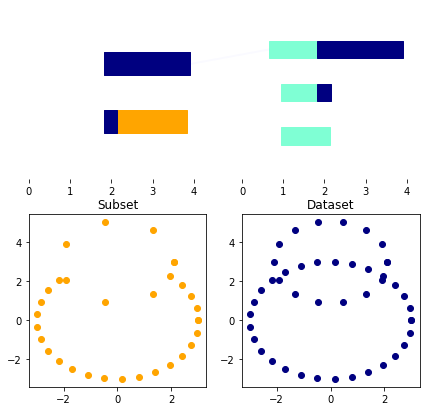

In [17]:
# Plot POints 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,7))
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(Y[:,0], Y[:,1], c="navy")
ax[1,0].set_title("Subset")
ax[1,1].set_title("Dataset")
ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
plt.savefig("plots/perfect_circles/two_circles_perfect.png")

In [18]:
%%capture
rng = default_rng(10)
for i in range(5):
    eps = 0.1 + 0.1*i
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    assert(IBloFunMatch_o["induced_matching_1"]==IBloFunMatch_o["block_function_1"])
    ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}")
    plt.savefig(f"plots/perfect_circles/two_circles_perfect_{i}.png")

WELCOME TO IBLOFUNMATCH!!!
sorted sample indices, total: 32
Reading distance Matrices.
Finished reading matrices and sample indices.
sorted S according to new order
stored new sorted distance matrix
Correctly checked inequality on dist_S and dist_X
Welcome to PerMoVEC!
The subcomplex contains 167 simplices  after collapse. 
   and has dimension 2 
The subcomplex contains 293 simplices  after collapse. 
   and has dimension 2 
Cycle columns image: 
Checking zero columns:
0 PM_matrix:
0, 
1, 
3, 
5, 
7, 
8, 
9, 
11, 
12, 
13, 
6, 
15, 
16, 
18, 
19, 
20, 
21, 
24, 
25, 
27, 
28, 
29, 
30, 
31, 
33, 
4, 6, 10, 15, 17, 20, 22, 23, 26, 28, 32, 
37, 
35, 39, 
34, 40, 
36, 41, 
38, 43, 
PM_matrix end
1 PM_matrix:
0, 1, 
0, 2, 
PM_matrix end
Returned from PerMoVEC
Sorting startpoint 0
sortstart: created indices
sortstart: sorted indices
0 31 31 31 31
1 31 31 31 31
2 31 31 31 31
3 31 31 31 31
4 31 31 31 31
5 31 31 31 31
6 31 31 31 31
7 31 31 31 31
8 31 31 31 31
9 31 31 31 31
10 31 31 31 31
11 3

In [ ]:
rng = default_rng(10)
eps=0.3
for i in range(8):
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}, iteration: {i}")
    plt.savefig(f"plots/perfect_circles/two_circ_const_noise_{i}.png")